<a href="https://colab.research.google.com/github/scalablefeaturekd/scalable_pink_team/blob/main/KD_cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
import torchvision
import torchvision.models as models
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## magic number

In [ ]:
drive_folder_p="/content/drive/MyDrive/cifar_100/"
weights_p=None
batch_size_p = 64
epochs_tuning_p = 1
epochs_training_p = 20
lr_p = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialization

## Prepare Data

In [ ]:
transform_list = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100", train=True, download=True, transform=transform_list)
test_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100", train=False, download=True, transform=transform_list)

100%|██████████| 169M/169M [00:04<00:00, 35.2MB/s]


## Basic Functions

In [ ]:
def distillation(student_logits, true_labels, teacher_logits, T=4.0, alpha=0.7):
    soft_target = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    hard_target = F.cross_entropy(student_logits, true_labels)
    return alpha * soft_target + (1 - alpha) * hard_target

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_experiment_results(
    student_model,
    best_hparams,
    best_model_history,
    all_stepwise_results,
    experiment_name="my_experiment",
    drive_folder="/content/drive/MyDrive/experiment_results/"
):
    """
    Save the student's state_dict and the experiment data (hparams, history, etc.)
    into Google Drive.

    Args:
        student_model (nn.Module): The trained student model.
        best_hparams (dict): Dictionary containing the best hyperparameters.
        best_model_history (list): The epoch-wise (test_loss, test_acc) for the best config.
        all_stepwise_results (dict): Records of all searches across the three steps.
        experiment_name (str): A name used to generate the output file names.
        drive_folder (str): The folder path in Google Drive where results are stored.

    Returns:
        (model_path, data_path): The paths of the saved model file (.pt) and data file (.pkl).
    """
    import os
    import torch
    import pickle

    # 1) Ensure the drive folder exists
    os.makedirs(drive_folder, exist_ok=True)

    # 2) Construct the file paths
    model_path = os.path.join(drive_folder, f"{experiment_name}_model.pt")
    data_path = os.path.join(drive_folder, f"{experiment_name}_data.pkl")

    # 3) Save the model's state_dict to a .pt file
    torch.save(student_model.state_dict(), model_path)
    print(f"Saved model to: {model_path}")

    # 4) Pack the other experiment data into one dict
    data_dict = {
        "best_hparams": best_hparams,
        "best_model_history": best_model_history,
        "all_stepwise_results": all_stepwise_results
    }

    # 5) Save the data_dict to a .pkl file
    with open(data_path, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Saved experiment data to: {data_path}")

    return model_path, data_path


In [ ]:
def load_results_from_drive(
    student_class,
    experiment_name="my_experiment",
    drive_folder="/content/drive/MyDrive/experiment_results/",
    device="cuda"
):
    """
    Load a student model's state_dict and related experiment data from Google Drive.

    Args:
        student_class: The class of the student network (e.g., StudentNet_MultiLayer).
        experiment_name: The name used to locate the .pt and .pkl files.
        drive_folder: The folder path in Google Drive where the files are stored.
        device: 'cuda' or 'cpu'.

    Returns:
        student_model (nn.Module): The loaded student model (in eval mode).
        best_hparams (dict): The best hyperparameters that were saved.
        best_model_history (list): The epoch-wise (test_loss, test_acc) for the best config.
        all_stepwise_results (dict): The full stepwise search records.
    """
    import os
    import torch
    import pickle

    # 1) Construct file paths
    model_path = os.path.join(drive_folder, f"{experiment_name}_model.pt")
    data_path = os.path.join(drive_folder, f"{experiment_name}_data.pkl")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")

    # 2) Re-instantiate the student model
    student_model = student_class().to(device)

    # 3) Load the model's state_dict
    student_model.load_state_dict(torch.load(model_path, map_location=device))
    student_model.eval()

    # 4) Load the other experiment data (best_hparams, best_model_history, etc.)
    with open(data_path, 'rb') as f:
        data_dict = pickle.load(f)

    best_hparams = data_dict["best_hparams"]
    best_model_history = data_dict["best_model_history"]
    all_stepwise_results = data_dict["all_stepwise_results"]

    print(f"Loaded model from {model_path}")
    print(f"Loaded experiment data from {data_path}")

    return student_model, best_hparams, best_model_history, all_stepwise_results


# Teacher Model

In [ ]:
class TeacherResNet50(nn.Module):
    def __init__(self):
        super(TeacherResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, 100)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)

        x = self.resnet50.layer1(x)
        layer1_out = x

        x = self.resnet50.layer2(x)
        layer2_out = x

        x = self.resnet50.layer3(x)
        layer3_out = x

        x = self.resnet50.layer4(x)
        layer4_out = x

        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet50.fc(x)

        # Return a dict of all layer outputs + final classifier output
        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output

In [ ]:
def train_teacher_femain_teacher_fe(model,device,train_loader,optimizer,epoch):
  model.train()
  trained_samples = 0

  for batch_idx,(data,target) in enumerate(train_loader):
    data,target = data.to(device),target.to(device)
    _,output = model(data)
    optimizer.zero_grad()
    loss = F.cross_entropy(output,target)
    loss.backward()
    optimizer.step()

    trained_samples += len(data)
    progress = math.ceil((batch_idx) / len(train_loader) * 50)
    print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
            (epoch, trained_samples,len(train_loader.dataset),'-' * progress + ">", progress * 2),end="")

def test_teacher_femain_teacher_fe(model,device,test_loader):
  # model.eval()
  # test_loss = 0
  # correct = 0
  # with torch.no_grad():
  #   for data,target in test_loader:
  #     data,target = data.to(device),target.to(device)
  #     _,output = model(data)
  #     test_loss += F.cross_entropy(output,target,reduction="sum").item()
  #     pred = output.argmax(dim=1, keepdim=True)
  #     correct += pred.eq(target.view_as(pred)).sum().item()
  # test_loss /= len(test_loader.dataset)



  # print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
  #       test_loss, correct, len(test_loader.dataset),
  #       100. * correct / len(test_loader.dataset)))
  # return test_loss, correct / len(test_loader.dataset)


    model.eval()
    test_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            _, output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            total_samples += data.size(0)

            # Top-1 Accuracy
            _, pred_top1 = output.max(dim=1)
            correct_top1 += pred_top1.eq(target).sum().item()

            # Top-5 Accuracy
            _, pred_top5 = output.topk(5, dim=1)
            # pred_top5 is shape (batch_size, 5)
            # check if target in these top-5 predictions
            match_top5 = pred_top5.eq(target.view(-1,1).expand_as(pred_top5))
            correct_top5 += match_top5.sum().item()

    test_loss /= total_samples
    top1_acc = 100.0 * correct_top1 / total_samples
    top5_acc = 100.0 * correct_top5 / total_samples

    print(
        "Test: average loss: {:.4f}, Top-1 Acc: {:.2f}%, Top-5 Acc: {:.2f}%".format(
            test_loss, top1_acc, top5_acc
        )
    )
    return test_loss, top1_acc, top5_acc

In [ ]:
def main_teacher_fe():
  batch_size = batch_size_p
  epochs = epochs_training_p
  torch.manual_seed(0)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  transform_list = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
  ])

  train_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100",train=True,download=True,transform=transform_list)
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle=True)
  test_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100",train=False,download=True,transform=transform_list)
  test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True)
  model = TeacherResNet50().to(device)
  #adadelta ==> very very very very slow
  # optimizer = torch.optim.Adadelta(model.parameters())
  lr = lr_p
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
  teacher_history = []
  for epoch in range(1,epochs+1):
    train_teacher_femain_teacher_fe(model,device,train_loader,optimizer,epoch)
    test_loss, test_acc_top1, test_acc_top5 = test_teacher_femain_teacher_fe(model,device,test_loader)
    teacher_history.append((test_loss, test_acc_top1, test_acc_top5))
  torch.save(model.state_dict(), "teacher_cifar100.pt")
  return model, teacher_history


In [ ]:
teacher_model,teacher_history=main_teacher_fe()

save_experiment_results(
    teacher_model,
    [],
    [],
    teacher_history,
    experiment_name="teacher_resnet50",
    drive_folder=drive_folder_p
)

Train epoch 1: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 1.2940, Top-1 Acc: 65.92%, Top-5 Acc: 92.11%
Train epoch 2: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 0.7456, Top-1 Acc: 78.04%, Top-5 Acc: 96.46%
Train epoch 3: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 0.6318, Top-1 Acc: 80.56%, Top-5 Acc: 97.30%
Train epoch 4: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 0.5743, Top-1 Acc: 82.28%, Top-5 Acc: 97.73%
Train epoch 5: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 0.5475, Top-1 Acc: 83.32%, Top-5 Acc: 97.86%
Train epoch 6: 50000/50000, [-------------------------------------------------->] 100%Test: average loss: 0.5307, Top-1 Acc: 83.90%, Top-5 Acc: 97.96%
Train epoch 7: 50000/50000, [-------------------------------------------------->] 100%Test: av

('/content/drive/MyDrive/cifar_100/teacher_resnet50_model.pt',
 '/content/drive/MyDrive/cifar_100/teacher_resnet50_data.pkl')

# Student-Resnet-18

## Model and Basic Functions

In [ ]:
class TeacherResNet50(nn.Module):
    def __init__(self):
        super(TeacherResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, 100)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)

        x = self.resnet50.layer1(x)
        layer1_out = x

        x = self.resnet50.layer2(x)
        layer2_out = x

        x = self.resnet50.layer3(x)
        layer3_out = x

        x = self.resnet50.layer4(x)
        layer4_out = x

        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet50.fc(x)

        # Return a dict of all layer outputs + final classifier output
        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output

In [ ]:
teacher_model = TeacherResNet50().to(device)
teacher_model.load_state_dict(torch.load("teacher_cifar100.pt"))
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

In [ ]:
class StudentResNet18(nn.Module):
    def __init__(self):
        super(StudentResNet18, self).__init__()
        self.resnet18 = models.resnet18(weights=weights_p)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, 100)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        layer1_out = x

        x = self.resnet18.layer2(x)
        layer2_out = x

        x = self.resnet18.layer3(x)
        layer3_out = x

        x = self.resnet18.layer4(x)
        layer4_out = x

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet18.fc(x)

        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output


In [ ]:
# ================== 1) Global channel dicts ==================
teacher_channels_dict = {
    'layer1': 256,
    'layer2': 512,
    'layer3': 1024,
    'layer4': 2048,
    'layer_preLogits': 2048
}

student_channels_dict = {
    'layer1': 64,
    'layer2': 128,
    'layer3': 256,
    'layer4': 512,
    'layer_preLogits': 512
}

def build_projections_for_fitnet(chosen_layers):
    """
    Build projection layers for FitNet based on the global teacher_channels_dict
    and student_channels_dict, specifically for the given chosen_layers.
    """
    import torch.nn as nn

    projections = nn.ModuleDict()

    for lay in chosen_layers:
        t_dim = teacher_channels_dict[lay]
        s_dim = student_channels_dict[lay]

        if t_dim == s_dim:
            projections[lay] = nn.Identity()
        else:
            if lay == "layer_preLogits":
                # a 2D feature -> use Linear
                layer_seq = nn.Sequential(
                    nn.Linear(t_dim, s_dim),
                    nn.ReLU()
                )
            else:
                # a 4D feature map -> use 1x1 Conv2d + BN + ReLU
                layer_seq = nn.Sequential(
                    nn.Conv2d(in_channels=t_dim, out_channels=s_dim, kernel_size=1),
                    nn.BatchNorm2d(s_dim),
                    nn.ReLU()
                )
            projections[lay] = layer_seq

    return projections


In [ ]:
def attention_map(feat_map):

    # feat_map: (B, C, H, W)
    # 1) mean of squares across channel
    am = feat_map.pow(2).mean(1, keepdim=True)   # (B, 1, H, W)
    # 2) L2 normalize
    am = F.normalize(am, p=2, dim=(2, 3))        # normalize across spatial dims
    return am


def at_loss(student_map, teacher_map):
    return F.mse_loss(student_map, teacher_map)

In [ ]:
def test_student(model, device, test_loader):
    """
    """

    model.eval()
    test_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            _, output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            total_samples += data.size(0)

            # Top-1 Accuracy
            _, pred_top1 = output.max(dim=1)
            correct_top1 += pred_top1.eq(target).sum().item()

            # Top-5 Accuracy
            _, pred_top5 = output.topk(5, dim=1)
            # pred_top5 is shape (batch_size, 5)
            # check if target in these top-5 predictions
            match_top5 = pred_top5.eq(target.view(-1,1).expand_as(pred_top5))
            correct_top5 += match_top5.sum().item()

    test_loss /= total_samples
    top1_acc = 100.0 * correct_top1 / total_samples
    top5_acc = 100.0 * correct_top5 / total_samples

    print(
        "Test: average loss: {:.4f}, Top-1 Acc: {:.2f}%, Top-5 Acc: {:.2f}%".format(
            test_loss, top1_acc, top5_acc
        )
    )
    return test_loss, top1_acc, top5_acc





## train one epoch

In [ ]:
def train_one_epoch_multi(
    kd_method,
    student_model,
    teacher_model,
    device,
    train_loader,
    optimizer,
    epoch,
    feature_based_alpha=0.3,
    chosen_layer_combo=('layer3',),
    response_based_alpha=0.9,
    T=4.0,
    projections=None
):

    import torch
    import torch.nn.functional as F

    mse_loss_fn = torch.nn.MSELoss()
    student_model.train()
    teacher_model.eval()
    trained_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # forward student
        student_feats, student_output = student_model(data)

        # forward teacher
        with torch.no_grad():
            teacher_feats, teacher_output = teacher_model(data)

        loss_fb_sum = 0.0
        if kd_method == "fitnet-kd":
            # Summation of MSE across chosen_layer_combo
            for lay in chosen_layer_combo:
                s_feat = student_feats[lay]
                t_feat = teacher_feats[lay].detach()

                # If we have a projection for this layer, call it
                if projections is not None and lay in projections:
                    t_feat = projections[lay](t_feat)

                loss_fb_sum += mse_loss_fn(s_feat, t_feat)

        elif kd_method == "at-kd":
            for lay in chosen_layer_combo:
                s_feat = student_feats[lay]
                t_feat = teacher_feats[lay].detach()
                s_att = attention_map(s_feat)
                t_att = attention_map(t_feat)
                loss_fb_sum += at_loss(s_att, t_att)

        loss_rb = 0.0
        loss_ce = 0.0
        if kd_method in ("fitnet-kd", "resp-kd", "at-kd"):
            loss_rb = distillation(
                student_output,
                target,
                teacher_output,
                T=T,
                alpha=response_based_alpha
            )
        elif kd_method == "no-kd":
            loss_ce = F.cross_entropy(student_output, target)

        # Weighted combination
        loss_fb = feature_based_alpha * loss_fb_sum
        loss_rb_final = (1 - feature_based_alpha) * loss_rb
        # print()
        # print(loss_fb,loss_rb_final,loss_ce)
        # print()
        total_loss = 20*loss_fb + loss_rb_final + loss_ce
        # print(total_loss)
        total_loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = (batch_idx + 1) / len(train_loader) * 50
        bar = f"[{'-' * int(progress)}>".ljust(51, ' ')
        print(
            f"\rTrain epoch {epoch}: {trained_samples}/{len(train_loader.dataset)}, "
            f"{bar} {int(progress)*2}%",
            end=""
        )

    print()


## Train 1 kd hparam set

In [ ]:
def train_kd_once(
    kd_method,
    teacher_model,
    device,
    train_dataset,
    test_dataset,
    chosen_layer_combo=('layer3',),
    feature_based_alpha=0.3,
    response_based_alpha=0.9,
    T=4.0,
    lr=None,
    epochs=None,
    projections=None
):
    """
    Train the student model once with a specified KD method.
    If kd_method == 'fitnet-kd', we may use 'projections' to map teacher feats -> student feats.
    """
    import torch.optim as optim
    from torch.utils.data import DataLoader

    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    if lr is None:
        lr = lr_p
    if epochs is None:
        epochs = epochs_tuning_p

    train_loader = DataLoader(train_dataset, batch_size=batch_size_p, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_p, shuffle=False)

    # Instantiate student
    student_model = StudentResNet18().to(device)

    # If fitnet-kd, add projection params to optimizer
    if kd_method == "fitnet-kd" and projections is not None:
        optimizer = optim.SGD(
            list(student_model.parameters()) + list(projections.parameters()),
            lr=lr,
            momentum=0.9
        )
    else:
        optimizer = optim.SGD(
            student_model.parameters(),
            lr=lr,
            momentum=0.9
        )



    history = []
    for epoch in range(1, epochs + 1):
        train_one_epoch_multi(
            kd_method=kd_method,
            student_model=student_model,
            teacher_model=teacher_model,
            device=device,
            train_loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            feature_based_alpha=feature_based_alpha,
            chosen_layer_combo=chosen_layer_combo,
            response_based_alpha=response_based_alpha,
            T=T,
            projections=projections
        )
        test_loss, test_acc_top1, test_acc_top5 = test_student(student_model, device, test_loader)
        history.append((test_loss, test_acc_top1, test_acc_top5))

    final_acc = history[-1][1]
    return final_acc, history, student_model


## Sequential Stepwise Grid Search

In [ ]:
def sequential_stepwise_grid_search(
    kd_method,
    teacher_model,
    device,
    train_dataset,
    test_dataset,
    grid_params,
    fixed_alpha=0.3,
    fixed_temperature=8.0,
    fixed_lr=None,
    epochs=None
):
    """
    Perform sequential (stepwise) grid search for different kd_method:
      - "no-kd"
      - "resp-kd": alpha -> response_based_alpha
      - "fitnet-kd"/"at-kd": alpha -> feature_based_alpha
      - (1) layer combo, (2) alpha, (3) temperature
    """
    if fixed_lr is None:
        fixed_lr = lr_p
    if epochs is None:
        epochs = epochs_tuning_p

    best_layer_combo = None
    best_alpha = fixed_alpha
    best_temperature = fixed_temperature

    all_stepwise_results = {
        'step1_layer_search': [],
        'step2_alpha_search': [],
        'step3_temperature_search': []
    }

    # Step 1: search best layer combo
    layers_candidates = grid_params.get('layers', [])
    if len(layers_candidates) == 0:
        print("[Warning] 'layers' list is empty. Skipping Step 1.")
    else:
        best_acc_for_layers = -1.0
        for layer_combo in layers_candidates:
            print(f"[Step1] kd_method={kd_method}, layer_combo={layer_combo}, alpha={fixed_alpha}, T={fixed_temperature}")

            # Distinguish alpha usage
            if kd_method == "resp-kd":
                # alpha -> response_based_alpha
                feature_based_alpha_val = 0.0
                response_based_alpha_val = fixed_alpha
            elif kd_method in ("fitnet-kd", "at-kd"):
                # alpha -> feature_based_alpha
                feature_based_alpha_val = fixed_alpha
                response_based_alpha_val = 0.9
            else:  # no-kd or others
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            # Possibly build FitNet projections if needed
            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=fixed_temperature,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step1_layer_search'].append({
                'kd_method': kd_method,
                'layer_combo': layer_combo,
                'alpha': fixed_alpha,
                'T': fixed_temperature,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_layers:
                best_acc_for_layers = final_acc
                best_layer_combo = layer_combo

        print(f"[Step1] Best layer_combo={best_layer_combo}, acc={best_acc_for_layers:.2f}")

    # Step 2: search best alpha
    alpha_candidates = grid_params.get('alpha', [])
    if len(alpha_candidates) == 0:
        print("[Warning] 'alpha' list is empty. Skipping Step 2.")
    else:
        best_acc_for_alpha = -1.0
        for alpha_val in alpha_candidates:
            print(f"[Step2] kd_method={kd_method}, alpha={alpha_val}, layer={best_layer_combo}, T={fixed_temperature}")

            if kd_method == "resp-kd":
                # alpha -> response_based_alpha
                feature_based_alpha_val = 0.0
                response_based_alpha_val = alpha_val
            elif kd_method in ("fitnet-kd", "at-kd"):
                # alpha -> feature_based_alpha
                feature_based_alpha_val = alpha_val
                response_based_alpha_val = 0.9
            else:
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(best_layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=best_layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=fixed_temperature,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step2_alpha_search'].append({
                'kd_method': kd_method,
                'layer_combo': best_layer_combo,
                'alpha': alpha_val,
                'T': fixed_temperature,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_alpha:
                best_acc_for_alpha = final_acc
                best_alpha = alpha_val

        print(f"[Step2] Best alpha={best_alpha}, acc={best_acc_for_alpha:.2f}")

    # Step 3: search best temperature
    temp_candidates = grid_params.get('temperature', [])
    if len(temp_candidates) == 0:
        print("[Warning] 'temperature' list is empty. Skipping Step 3.")
    else:
        best_acc_for_temp = -1.0
        for T_val in temp_candidates:
            print(f"[Step3] kd_method={kd_method}, T={T_val}, layer={best_layer_combo}, alpha={best_alpha}")

            # apply alpha usage
            if kd_method == "resp-kd":
                feature_based_alpha_val = 0.0
                response_based_alpha_val = best_alpha
            elif kd_method in ("fitnet-kd", "at-kd"):
                feature_based_alpha_val = best_alpha
                response_based_alpha_val = 0.9
            else:
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(best_layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=best_layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=T_val,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step3_temperature_search'].append({
                'kd_method': kd_method,
                'layer_combo': best_layer_combo,
                'alpha': best_alpha,
                'T': T_val,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_temp:
                best_acc_for_temp = final_acc
                best_temperature = T_val

        print(f"[Step3] Best temperature={best_temperature}")

    # Final training with best hyperparams
    print(f"\n[Final] Training with best hyperparams (kd_method={kd_method})...")
    # apply alpha usage
    if kd_method == "resp-kd":
        feature_based_alpha_val = 0.0
        response_based_alpha_val = best_alpha
    elif kd_method in ("fitnet-kd", "at-kd"):
        feature_based_alpha_val = best_alpha
        response_based_alpha_val = 0.9
    else:
        feature_based_alpha_val = 0.0
        response_based_alpha_val = 0.0

    if kd_method == "fitnet-kd":
        proj_final = build_projections_for_fitnet(best_layer_combo).to(device)
    else:
        proj_final = None

    final_acc, best_model_history, student_model = train_kd_once(
        kd_method=kd_method,
        teacher_model=teacher_model,
        device=device,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        chosen_layer_combo=best_layer_combo,
        feature_based_alpha=feature_based_alpha_val,
        response_based_alpha=response_based_alpha_val,
        T=best_temperature,
        lr=fixed_lr,
        epochs=epochs_training_p,
        projections=proj_final
    )
    print(f"[Final] Final test accuracy with best hyperparams = {final_acc:.2f}")

    best_hparams = {
        'kd_method': kd_method,
        'layer_combo': best_layer_combo,
        'alpha': best_alpha,
        'temperature': best_temperature
    }

    return student_model, best_hparams, best_model_history, all_stepwise_results


# Student-Resnet-18 -- Call grid search

In [ ]:
kd_method="no-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [],
    "alpha": [],
    "temperature": []
}

print(f"=== {kd_method} Search ===")

student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,   #won't be used, but we'll still pass it
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.3,         #won't be used, but we'll still pass it
    fixed_temperature=8.0,   #won't be used, but we'll still pass it
)



save_experiment_results(
    student_model_nokd,
    best_hparams_nokd,
    best_history_nokd,
    all_res_nokd,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_nokd)
print(best_history_nokd)
print(all_res_nokd)
# print(student_model_nokd)


=== no-kd Search ===
[Warning] 'layers' list is empty. Skipping Step 1.
[Warning] 'alpha' list is empty. Skipping Step 2.
[Warning] 'temperature' list is empty. Skipping Step 3.

[Final] Training with best hyperparams (kd_method=no-kd)...
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.8281, Top-1 Acc: 11.60%, Top-5 Acc: 33.53%
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.5122, Top-1 Acc: 16.78%, Top-5 Acc: 41.94%
Train epoch 3: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.3083, Top-1 Acc: 20.61%, Top-5 Acc: 48.07%
Train epoch 4: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.1590, Top-1 Acc: 23.32%, Top-5 Acc: 51.94%
Train epoch 5: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 2.9398, Top-1 Acc: 27.28%, Top-5 Acc: 57.00%
Train 

In [ ]:
kd_method="resp-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [],
    "alpha": [0.9],
    "temperature": [8]
}


print(f"=== {kd_method} Search ===")

student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.9,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_resp, best_hparams_resp, best_history_resp, all_res_resp,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_resp)
print(best_history_resp)
print(all_res_resp)
# print(student_model_resp)

=== resp-kd Search ===
[Warning] 'layers' list is empty. Skipping Step 1.
[Step2] kd_method=resp-kd, alpha=0.9, layer=None, T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.5575, Top-1 Acc: 15.09%, Top-5 Acc: 42.53%
[Step2] Best alpha=0.9, acc=15.09
[Step3] kd_method=resp-kd, T=8, layer=None, alpha=0.9
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.6516, Top-1 Acc: 13.99%, Top-5 Acc: 40.69%
[Step3] Best temperature=8

[Final] Training with best hyperparams (kd_method=resp-kd)...
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.5605, Top-1 Acc: 15.38%, Top-5 Acc: 42.93%
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.0439, Top-1 Acc: 24.61%, Top-5 Acc: 58.04%
Train epoch 3: 50000/50000, [--------------------------------------------------> 100%
Te

In [ ]:
from itertools import combinations

fitnet_layers = ["layer_preLogits"]
fitnet_combinations = []

for r in range(1, 2):
    for combo in combinations(fitnet_layers, r):
        fitnet_combinations.append(list(combo))

print(fitnet_combinations)


In [ ]:
kd_method="fitnet-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [["layer_preLogits"]],
    "alpha": [0.1],
    "temperature": []
}


print(f"=== {kd_method} Search ===")

student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.9,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_fit, best_hparams_fit, best_history_fit, all_res_fit,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_fit)
print(best_history_fit)
print(all_res_fit)
# print(student_model_fit)

=== fitnet-kd Search ===
[Step1] kd_method=fitnet-kd, layer_combo=['layer_preLogits'], alpha=0.9, T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 4.6051, Top-1 Acc: 1.09%, Top-5 Acc: 5.33%
[Step1] Best layer_combo=['layer_preLogits'], acc=1.09
[Step2] kd_method=fitnet-kd, alpha=0.1, layer=['layer_preLogits'], T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.7386, Top-1 Acc: 10.64%, Top-5 Acc: 34.16%
[Step2] Best alpha=0.1, acc=10.64
[Warning] 'temperature' list is empty. Skipping Step 3.

[Final] Training with best hyperparams (kd_method=fitnet-kd)...
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.7515, Top-1 Acc: 11.35%, Top-5 Acc: 34.39%
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.2135, Top-1 Acc: 19.55%, Top-5 Acc: 50.08%
Train epoch

In [ ]:
from itertools import combinations

at_layers = ["layer4", "layer1", "layer2", "layer3" ]
at_combinations = []

for r in range(1, 3):
    for combo in combinations(at_layers, r):
        at_combinations.append(list(combo))

print(at_combinations)

In [ ]:
kd_method="at-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [["layer4","layer2"]],
    "alpha": [0.1],
    "temperature": []
}


print(f"=== {kd_method} Search ===")

student_model_at, best_hparams_at, best_history_at, all_res_at = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.9,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_at, best_hparams_at, best_history_at, all_res_at,
    experiment_name="student_resnet18_"+str(kd_method)+"_alpha=0.1",
    drive_folder=drive_folder_p
)


student_model_at, best_hparams_at, best_history_at, all_res_at = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method)+"_alpha=0.1",
    drive_folder=drive_folder_p,
    device=device
)



print(best_hparams_at)
print(best_history_at)
print(all_res_at)
# print(student_model_at)

=== at-kd Search ===
[Step1] kd_method=at-kd, layer_combo=['layer4', 'layer2'], alpha=0.9, T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 4.1426, Top-1 Acc: 5.09%, Top-5 Acc: 20.69%
[Step1] Best layer_combo=['layer4', 'layer2'], acc=5.09
[Step2] kd_method=at-kd, alpha=0.1, layer=['layer4', 'layer2'], T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.5713, Top-1 Acc: 14.84%, Top-5 Acc: 42.55%
[Step2] Best alpha=0.1, acc=14.84
[Warning] 'temperature' list is empty. Skipping Step 3.

[Final] Training with best hyperparams (kd_method=at-kd)...
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.5589, Top-1 Acc: 14.89%, Top-5 Acc: 42.10%
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 3.0932, Top-1 Acc: 24.09%, Top-5 Acc: 56.01%
Train epoch 3: 50000/50

#Student-Resnet-18 -- Presenting

## load the model and results from google drive

In [ ]:
teacher_model = TeacherResNet50().to(device)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/cifar_100/teacher_resnet50_model.pt"))
teacher_model.eval()

import pickle

with open("/content/drive/MyDrive/cifar_100/teacher_resnet50_data.pkl", "rb") as f:
    teacher_history = pickle.load(f)

print(teacher_model)
print(teacher_history)

TeacherResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
kd_method="no-kd"

student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_nokd)
print(best_history_nokd)
print(all_res_nokd)
# print(student_model_nokd)

Loaded model from /content/drive/MyDrive/cifar_100/student_resnet18_no-kd_model.pt
Loaded experiment data from /content/drive/MyDrive/cifar_100/student_resnet18_no-kd_data.pkl
{'kd_method': 'no-kd', 'layer_combo': None, 'alpha': 0.3, 'temperature': 8.0}
[(3.8280919448852537, 11.6, 33.53), (3.51224188079834, 16.78, 41.94), (3.308269213104248, 20.61, 48.07), (3.1589564140319824, 23.32, 51.94), (2.9397715824127197, 27.28, 57.0), (2.786795391845703, 30.24, 61.03), (2.6678799476623536, 32.17, 63.43), (2.5388184089660646, 34.92, 66.97), (2.458816164779663, 36.57, 67.76), (2.3841367404937746, 38.14, 69.66), (2.3071559535980226, 39.76, 71.23), (2.2470387287139895, 40.93, 71.94), (2.1194929943084717, 43.33, 75.13), (2.071721192932129, 44.8, 75.96), (1.999636727142334, 46.57, 77.18), (1.956063677597046, 47.41, 78.03), (1.9337258424758912, 48.35, 78.55), (1.852353216934204, 50.03, 79.82), (1.879179552268982, 49.4, 79.44), (1.8147116735458375, 50.59, 80.49)]
{'step1_layer_search': [], 'step2_alpha

In [ ]:
kd_method="resp-kd"

student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_resp)
print(best_history_resp)
print(all_res_resp)
# print(student_model_resp)

Loaded model from /content/drive/MyDrive/cifar_100/student_resnet18_resp-kd_model.pt
Loaded experiment data from /content/drive/MyDrive/cifar_100/student_resnet18_resp-kd_data.pkl
{'kd_method': 'resp-kd', 'layer_combo': None, 'alpha': 0.9, 'temperature': 8}
[(3.5604634571075437, 15.38, 42.93), (3.0439187965393066, 24.61, 58.04), (2.7094352283477785, 31.94, 65.52), (2.4551161254882814, 38.01, 72.48), (2.207974491119385, 43.16, 77.26), (2.0248348720550537, 48.22, 80.11), (1.8060126792907716, 52.96, 83.41), (1.6848697090148925, 55.61, 85.46), (1.837586611175537, 55.29, 84.87), (1.587073245048523, 59.06, 87.9), (1.6563975734710694, 59.48, 87.33), (1.5399413373947144, 61.97, 88.69), (1.4560424537658692, 63.18, 89.53), (1.5546760932922363, 62.23, 88.82), (1.4484396423339845, 64.61, 90.25), (1.4162961574554442, 65.59, 90.79), (1.3971210863113404, 66.14, 90.54), (1.4415260684967042, 65.82, 90.24), (1.4162017894744874, 66.36, 90.64), (1.4094324312210083, 67.16, 90.68)]
{'step1_layer_search': []

In [ ]:
kd_method="fitnet-kd"

student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_fit)
print(best_history_fit)
print(all_res_fit)
# print(student_model_fit)

Loaded model from /content/drive/MyDrive/cifar_100/student_resnet18_fitnet-kd_model.pt
Loaded experiment data from /content/drive/MyDrive/cifar_100/student_resnet18_fitnet-kd_data.pkl
{'kd_method': 'fitnet-kd', 'layer_combo': ['layer_preLogits'], 'alpha': 0.1, 'temperature': 8.0}
[(3.751454903411865, 11.35, 34.39), (3.213482074737549, 19.55, 50.08), (2.9736532577514647, 24.98, 57.49), (2.547502671813965, 33.17, 68.44), (2.2469552433013917, 39.44, 74.49), (2.0933397888183594, 44.04, 78.08), (1.903768354034424, 48.89, 81.49), (1.7622137882232667, 51.41, 83.92), (1.8064002464294433, 52.98, 83.96), (1.6201259317398071, 56.43, 86.56), (1.7442668643951416, 55.81, 85.4), (1.594297296142578, 58.79, 87.43), (1.47780593624115, 61.52, 88.54), (1.4832822629928588, 62.43, 89.14), (1.4220382482528686, 63.32, 89.8), (1.4371961086273193, 64.09, 89.54), (1.4220309720993043, 64.09, 89.93), (1.4910610513687135, 64.48, 89.7), (1.416907218170166, 65.0, 90.08), (1.3812625915527343, 66.39, 90.57)]
{'step1_la

In [ ]:
kd_method="at-kd"

student_model_at, best_hparams_at, best_history_at, all_res_at = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method)+"_alpha=0.1",
    drive_folder=drive_folder_p,
    device=device
)

print(best_hparams_at)
print(best_history_at)
print(all_res_at)
# print(student_model_at)

Loaded model from /content/drive/MyDrive/cifar_100/student_resnet18_at-kd_alpha=0.1_model.pt
Loaded experiment data from /content/drive/MyDrive/cifar_100/student_resnet18_at-kd_alpha=0.1_data.pkl
{'kd_method': 'at-kd', 'layer_combo': ['layer4', 'layer2'], 'alpha': 0.1, 'temperature': 8.0}
[(3.558936840057373, 14.89, 42.1), (3.0931651714324953, 24.09, 56.01), (2.7414916301727295, 30.75, 64.67), (2.544292324066162, 36.41, 70.73), (2.2450049797058105, 42.46, 76.38), (2.0698960853576662, 46.72, 79.25), (1.8748064529418946, 51.34, 82.24), (1.7510607971191405, 54.01, 84.37), (1.8389323997497558, 54.12, 84.46), (1.5950439994812011, 58.88, 87.38), (1.7070441818237305, 58.4, 86.15), (1.623796671295166, 59.98, 87.84), (1.5092067113876342, 61.89, 88.94), (1.5123355802536012, 62.66, 89.19), (1.411241275024414, 64.81, 90.37), (1.4715811275482178, 64.66, 89.82), (1.3997815910339355, 65.7, 90.08), (1.666873603630066, 62.95, 88.61), (1.3999939163208008, 66.35, 91.09), (1.446664204788208, 65.76, 90.06)

In [ ]:
print(teacher_history)
print(best_history_nokd)
print(best_history_fit)
print(best_history_resp)
print(best_history_at)

{'best_hparams': [], 'best_model_history': [], 'all_stepwise_results': [(1.2940138362884521, 65.92, 92.11), (0.7455822678565979, 78.04, 96.46), (0.6318305637359619, 80.56, 97.3), (0.5742529817581177, 82.28, 97.73), (0.547524534702301, 83.32, 97.86), (0.5306591126203537, 83.9, 97.96), (0.5234089707136154, 84.27, 97.9), (0.5202079580783844, 84.41, 98.06), (0.5229988017082214, 84.58, 97.99), (0.5191596480846405, 84.61, 98.01), (0.5332170770645142, 84.83, 97.96), (0.5365737077236176, 84.66, 98.15), (0.5392890111923218, 85.01, 98.03), (0.5393851319313049, 85.12, 98.06), (0.5557823073863983, 84.78, 98.16), (0.5710515735149384, 84.97, 98.02), (0.5707641505241394, 84.85, 98.16), (0.5774012202739716, 84.88, 98.05), (0.5805581346750259, 85.17, 98.07), (0.6023196788787841, 85.11, 98.07)]}
[(3.8280919448852537, 11.6, 33.53), (3.51224188079834, 16.78, 41.94), (3.308269213104248, 20.61, 48.07), (3.1589564140319824, 23.32, 51.94), (2.9397715824127197, 27.28, 57.0), (2.786795391845703, 30.24, 61.03), 

## Comparing KDs

In [ ]:
def plot_final_results(
    hist_teacher,
    hist_nokd,      # no KD
    hist_fit,       # fitnet KD
    hist_resp,      # response KD
    hist_at         # attention transfer KD
):
    # extract
    loss_teacher = [h[0] for h in hist_teacher['all_stepwise_results']]
    acc_teacher  = [h[1] for h in hist_teacher['all_stepwise_results']]

    loss_nokd = [h[0] for h in hist_nokd]
    acc_nokd  = [h[1] for h in hist_nokd]

    loss_fit = [h[0] for h in hist_fit]
    acc_fit  = [h[1] for h in hist_fit]

    loss_resp = [h[0] for h in hist_resp]
    acc_resp  = [h[1] for h in hist_resp]

    loss_at = [h[0] for h in hist_at]
    acc_at  = [h[1] for h in hist_at]

    epochs = range(1, len(hist_nokd)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc_teacher, label="Teacher", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_nokd, label="Student without KD", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_resp, label="Student with Response-KD", marker='o')
    plt.plot(epochs, acc_fit, label="Student with FitNet-KD (No Logits Added)", marker='o')
    plt.plot(epochs, acc_at, label="Student with AT-KD (No Logits Added)", marker='o')
    plt.legend()
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss_teacher, label="Teacher", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_nokd, label="Student without KD", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_resp, label="Student with Response-KD", marker='o')
    plt.plot(epochs, loss_fit, label="Student with FitNet-KD (No Logits Added)", marker='o')
    plt.plot(epochs, loss_at, label="Student with AT-KD (No Logits Added)", marker='o')
    plt.legend()
    plt.title("Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_final_results_with_top5(
    hist_teacher,
    hist_nokd,
    hist_fit,
    hist_resp,
    hist_at
):
    import matplotlib.pyplot as plt

    # 1) Parse the teacher history (loss, top1, top5)
    loss_teacher = [h[0] for h in hist_teacher['all_stepwise_results']]
    acc_teacher_top1 = [h[1] for h in hist_teacher['all_stepwise_results']]
    acc_teacher_top5 = [h[2] for h in hist_teacher['all_stepwise_results']]

    # 2) Parse the no-KD history
    loss_nokd = [h[0] for h in hist_nokd]
    acc_nokd_top1 = [h[1] for h in hist_nokd]
    acc_nokd_top5 = [h[2] for h in hist_nokd]

    # 3) Parse the FitNet KD history
    loss_fit = [h[0] for h in hist_fit]
    acc_fit_top1 = [h[1] for h in hist_fit]
    acc_fit_top5 = [h[2] for h in hist_fit]

    # 4) Parse the Resp-KD history
    loss_resp = [h[0] for h in hist_resp]
    acc_resp_top1 = [h[1] for h in hist_resp]
    acc_resp_top5 = [h[2] for h in hist_resp]

    # 5) Parse the AT-KD history
    loss_at = [h[0] for h in hist_at]
    acc_at_top1 = [h[1] for h in hist_at]
    acc_at_top5 = [h[2] for h in hist_at]

    # We assume all have the same number of epochs
    epochs = range(1, len(hist_nokd) + 1)

    # Create a figure with two subplots: left for accuracy (top-1 & top-5), right for loss
    plt.figure(figsize=(12, 5))

    # =========== Left Subplot: top-1 & top-5 Accuracy ===========
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_teacher_top1, label="Teacher Top-1", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_teacher_top5, label="Teacher Top-5", marker='o', linestyle='--')

    plt.plot(epochs, acc_nokd_top1, label="No KD Top-1", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_nokd_top5, label="No KD Top-5", marker='o', linestyle='--')

    plt.plot(epochs, acc_resp_top1, label="Resp-KD Top-1", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_resp_top5, label="Resp-KD Top-5", marker='o', linestyle='--')

    plt.plot(epochs, acc_fit_top1, label="FitNet-KD Top-1", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_fit_top5, label="FitNet-KD Top-5", marker='o', linestyle='--')

    plt.plot(epochs, acc_at_top1, label="AT-KD Top-1", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_at_top5, label="AT-KD Top-5", marker='o', linestyle='--')

    plt.title("Top-1 and Top-5 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # =========== Right Subplot: Loss ===========
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_teacher, label="Teacher Loss", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_nokd, label="No KD Loss", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_resp, label="Resp-KD Loss", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_fit, label="FitNet-KD Loss", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_at, label="AT-KD Loss", marker='o', linestyle='dotted')

    plt.title("Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_final_results_with_top5_in_three_plots(
    hist_teacher,
    hist_nokd,
    hist_fit,
    hist_resp,
    hist_at
):
    import matplotlib.pyplot as plt

    # Teacher history is stored in a dict with "all_stepwise_results"
    teacher_list = hist_teacher["all_stepwise_results"]

    # Parse teacher (loss, top1, top5)
    loss_teacher      = [h[0] for h in teacher_list]
    acc_teacher_top1  = [h[1] for h in teacher_list]
    acc_teacher_top5  = [h[2] for h in teacher_list]

    # Parse no-KD
    loss_nokd         = [h[0] for h in hist_nokd]
    acc_nokd_top1     = [h[1] for h in hist_nokd]
    acc_nokd_top5     = [h[2] for h in hist_nokd]

    # Parse FitNet KD
    loss_fit          = [h[0] for h in hist_fit]
    acc_fit_top1      = [h[1] for h in hist_fit]
    acc_fit_top5      = [h[2] for h in hist_fit]

    # Parse Resp-KD
    loss_resp         = [h[0] for h in hist_resp]
    acc_resp_top1     = [h[1] for h in hist_resp]
    acc_resp_top5     = [h[2] for h in hist_resp]

    # Parse AT-KD
    loss_at           = [h[0] for h in hist_at]
    acc_at_top1       = [h[1] for h in hist_at]
    acc_at_top5       = [h[2] for h in hist_at]

    # We assume each experiment has the same number of epochs
    epochs = range(1, len(hist_nokd) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # === Subplot 1: Top-1 Accuracy ===
    axes[0].plot(epochs, acc_teacher_top1, label="Teacher Top-1", marker='o', linestyle='dotted')
    axes[0].plot(epochs, acc_nokd_top1,    label="No KD Top-1",   marker='o', linestyle='dotted')
    axes[0].plot(epochs, acc_resp_top1,    label="Resp-KD Top-1", marker='o', linestyle='dotted')
    axes[0].plot(epochs, acc_fit_top1,     label="FitNet-KD Top-1", marker='o', linestyle='dotted')
    axes[0].plot(epochs, acc_at_top1,      label="AT-KD Top-1",   marker='o', linestyle='dotted')
    axes[0].set_title("Top-1 Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].grid(True)
    axes[0].legend()

    # === Subplot 2: Top-5 Accuracy ===
    axes[1].plot(epochs, acc_teacher_top5, label="Teacher Top-5", marker='o', linestyle='--')
    axes[1].plot(epochs, acc_nokd_top5,    label="No KD Top-5",   marker='o', linestyle='--')
    axes[1].plot(epochs, acc_resp_top5,    label="Resp-KD Top-5", marker='o', linestyle='--')
    axes[1].plot(epochs, acc_fit_top5,     label="FitNet-KD Top-5", marker='o', linestyle='--')
    axes[1].plot(epochs, acc_at_top5,      label="AT-KD Top-5",   marker='o', linestyle='--')
    axes[1].set_title("Top-5 Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].grid(True)
    axes[1].legend()

    # === Subplot 3: Loss ===
    axes[2].plot(epochs, loss_teacher, label="Teacher Loss", marker='o', linestyle='dotted')
    axes[2].plot(epochs, loss_nokd,    label="No KD Loss",   marker='o', linestyle='dotted')
    axes[2].plot(epochs, loss_resp,    label="Resp-KD Loss", marker='o', linestyle='dotted')
    axes[2].plot(epochs, loss_fit,     label="FitNet-KD Loss", marker='o', linestyle='dotted')
    axes[2].plot(epochs, loss_at,      label="AT-KD Loss",   marker='o', linestyle='dotted')
    axes[2].set_title("Test Loss")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


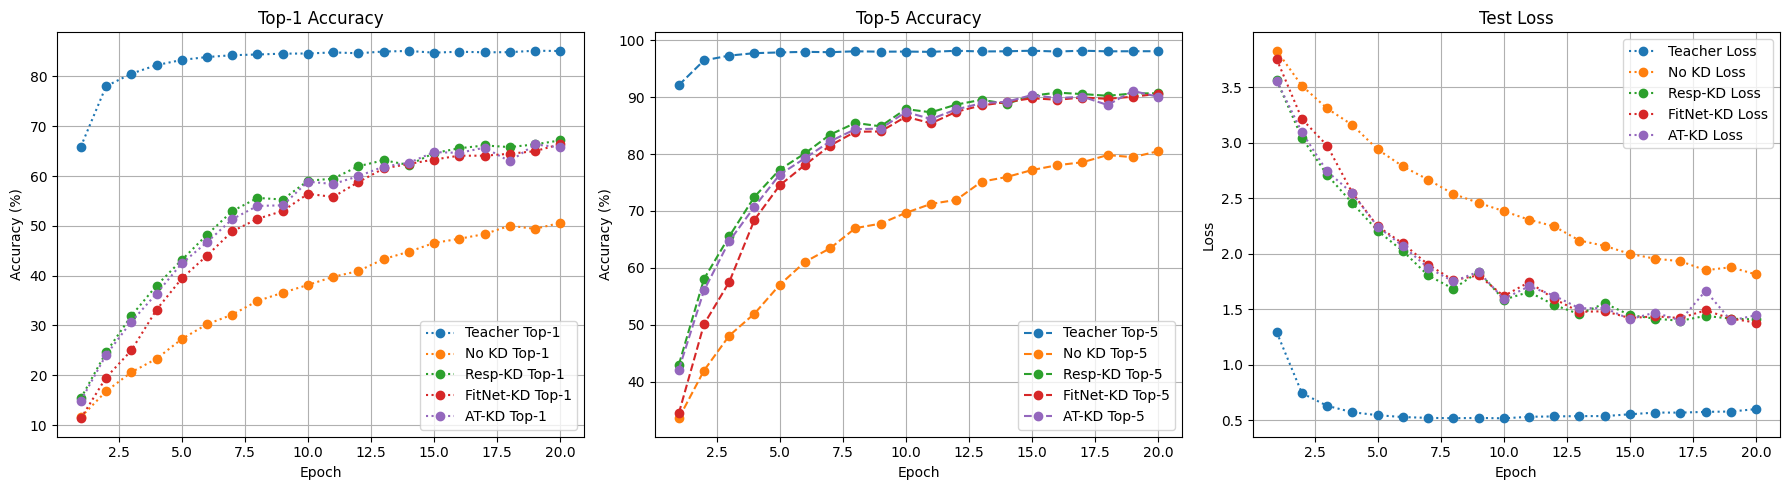

In [ ]:
plot_final_results_with_top5_in_three_plots(teacher_history, best_history_nokd, best_history_fit, best_history_resp, best_history_at)
